# Mumbai Property Price Prediction Model:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Establishing Connection with Database:

In [2]:
conn = sqlite3.connect('real_estate.db')
conn

In [3]:
df = pd.read_sql_query("select * from properties",conn)
print(df.shape)
df.head(3)

(58080, 11)


,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price
0,New Property,Unfurnished,3,992,3,None,Dec '27,Sion,19.052807,72.872584,33150000.0
1,New Property,Semi-Furnished,2,580,2,None,Dec '26,Navghar Road,19.304890,72.866211,11054551.0
2,New Property,Unfurnished,2,795,2,1,Sep '27,Andheri East,19.106338,72.869613,25000000.0


In [4]:
df.describe()

,latitude,longitude,price
count,55043.000000,55043.000000,5.792200e+04
mean,18.952293,73.012310,4.450860e+07
std,1.069976,0.930113,6.141094e+07
min,9.023547,19.145018,1.000000e+05
25%,19.057763,72.836970,2.280700e+07
50%,19.148916,72.863440,3.282500e+07
75%,19.205002,72.879561,4.674000e+07
max,21.100768,79.094337,9.680000e+09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58080 entries, 0 to 58079
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   property_type   58066 non-null  object 
 1   furnish_status  57725 non-null  object 
 2   bedrooms        58080 non-null  object 
 3   carpet_area     58080 non-null  object 
 4   bathrooms       57896 non-null  object 
 5   balconies       30054 non-null  object 
 6   poss_status     57816 non-null  object 
 7   location        57658 non-null  object 
 8   latitude        55043 non-null  float64
 9   longitude       55043 non-null  float64
 10  price           57922 non-null  float64
dtypes: float64(3), object(8)
memory usage: 4.9+ MB


## Data Cleaning and EDA:


#### Fixing datatype mismatch :

In [6]:
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce').astype('Int64')
df['carpet_area'] = pd.to_numeric(df['carpet_area'], errors='coerce').astype('Int64')
df['balconies'] = pd.to_numeric(df['balconies'], errors='coerce').astype('Int64')
df['price'] = pd.to_numeric(df['price'], errors='coerce').astype('Int64')
df['bathrooms'] = pd.to_numeric(df['bathrooms'],errors='coerce').astype('Int64')

print(df.dtypes)

property_type      object
furnish_status     object
bedrooms            Int64
carpet_area         Int64
bathrooms           Int64
balconies           Int64
poss_status        object
location           object
latitude          float64
longitude         float64
price               Int64
dtype: object


### Imputing and Fixing Null Values:

In [7]:
print("Null values in the dataset")
print(df.isna().sum())

Null values in the dataset
property_type        14
furnish_status      355
bedrooms             62
carpet_area         227
bathrooms           209
balconies         28048
poss_status         264
location            422
latitude           3037
longitude          3037
price               158
dtype: int64


In [8]:
df['balconies'].fillna(0,inplace=True)
print(df.isna().sum())

property_type       14
furnish_status     355
bedrooms            62
carpet_area        227
bathrooms          209
balconies            0
poss_status        264
location           422
latitude          3037
longitude         3037
price              158
dtype: int64


In [9]:
df['bedrooms'].fillna(0,inplace=True)
print(df.isna().sum())

property_type       14
furnish_status     355
bedrooms             0
carpet_area        227
bathrooms          209
balconies            0
poss_status        264
location           422
latitude          3037
longitude         3037
price              158
dtype: int64


In [10]:
df.dropna(subset=['price'], inplace=True)
print(df.isna().sum())

property_type        3
furnish_status     249
bedrooms             0
carpet_area        153
bathrooms          104
balconies            0
poss_status        150
location           403
latitude          2950
longitude         2950
price                0
dtype: int64


In [11]:
df.dropna(inplace=True)
print(df.shape)
print(df.isna().sum())

(54872, 11)
property_type     0
furnish_status    0
bedrooms          0
carpet_area       0
bathrooms         0
balconies         0
poss_status       0
location          0
latitude          0
longitude         0
price             0
dtype: int64


In [12]:
print(df.shape)
df.head(3)

(54872, 11)


,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price
0,New Property,Unfurnished,3,992,3,0,Dec '27,Sion,19.052807,72.872584,33150000
1,New Property,Semi-Furnished,2,580,2,0,Dec '26,Navghar Road,19.304890,72.866211,11054551
2,New Property,Unfurnished,2,795,2,1,Sep '27,Andheri East,19.106338,72.869613,25000000


### Modifying Column Values:

In [13]:
categorical_cols = df.select_dtypes(exclude=['Int64','float64']).columns
categorical_cols

Index(['property_type', 'furnish_status', 'poss_status', 'location'], dtype='object')

In [14]:
for col in categorical_cols:
    print(df[col].nunique())
    print(df[col].unique())

4
['New Property' 'Resale' 'Rent' 'Other']
3
['Unfurnished' 'Semi-Furnished' 'Furnished']
32
["Dec '27" "Dec '26" "Sep '27" 'Ready to Move' "Aug '29" "Oct '29"
 "Mar '27" "Dec '29" "Dec '25" "Jun '26" "Dec '30" "Jun '30" "Dec '28"
 'Ready To Move' "Jan '28" "Jun '25" "May '29" "Jun '27" "Oct '31"
 "Mar '28" "Dec '31" "Sep '30" "Oct '28" "Jul '29" "Sep '28" "Mar '29"
 "Sep '26" "May '26" 'Under Construction' "Jun '31" 'Immediately'
 "May '28"]
516
['Sion' 'Navghar Road' 'Andheri East' 'Kandivali West' 'Mulund West'
 'Borivali East' 'Byculla East' 'Mira Road Area' 'Bandra East'
 'Goregaon West' 'Andheri West' 'Wadala East' 'Juhu' 'Powai'
 'Kandivali East' 'Borivali West' 'Chembur' 'Wadala' 'Lower Parel'
 'Jogeshwari Vikhroli Link Road' 'Worli' 'Vikhroli' 'Mira Road East'
 'Bandra Kurla Complex' 'Prabhadevi' 'Goregaon' 'Byculla'
 'Mira Bhayandar Road' 'Sewri' 'Mahalakshmi' 'Lower Parel West'
 'Dadar East' 'Matunga East' 'Tardeo' 'Bhandup' 'Vasai West' 'Malad East'
 'Vikhroli West' 'Gorega

In [15]:
# Changed other to resale, and removed rows with rent.

df['property_type'].replace({'Other':'Resale'},inplace=True)
df = df.query('property_type != "Rent"')
df['property_type'].unique()

array(['New Property', 'Resale'], dtype=object)

In [16]:
# Modifying values in poss_status: converting all month rows data with 'Under Construction'
print("Unique values in poss_status column",df['poss_status'].unique())

df['poss_status'] = df['poss_status'].apply(lambda x: x if x in ['Under Construction', 'Immediately', 'Ongoing', 'Ready To Move','Ready to Move'] else 'Under Construction')
df['poss_status'].replace({'Ready To Move':'Ready to Move','Ongoing':'Under Construction'},inplace=True)
print("Unique values after fixing ",df['poss_status'].unique())

Unique values in poss_status column ["Dec '27" "Dec '26" "Sep '27" 'Ready to Move' "Aug '29" "Oct '29"
 "Mar '27" "Dec '29" "Dec '25" "Jun '26" "Dec '30" "Jun '30" "Dec '28"
 'Ready To Move' "Jan '28" "Jun '25" "May '29" "Jun '27" "Oct '31"
 "Mar '28" "Dec '31" "Sep '30" "Oct '28" "Jul '29" "Sep '28" "Mar '29"
 "Sep '26" "May '26" 'Under Construction' "Jun '31" "May '28"]
Unique values after fixing  ['Under Construction' 'Ready to Move']


In [17]:
# Fixing values in poss_staus based on domain knowledge: A property cannot both be resale and under construction.
print(df.query('property_type =="Resale" & poss_status == "Under Construction"').shape)

df.loc[(df['property_type'] == 'Resale') & (df['poss_status'] == 'Under Construction'), 'poss_status'] = 'Ready to Move'
print(df.query('property_type =="Resale" & poss_status == "Under Construction"').shape)

(229, 11)
(0, 11)


In [18]:
numeric_cols = df.select_dtypes(exclude='object').columns
numeric_cols

Index(['bedrooms', 'carpet_area', 'bathrooms', 'balconies', 'latitude',
       'longitude', 'price'],
      dtype='object')

In [19]:
# Recheking the applied transformation on categorical column.
for col in categorical_cols.drop('location'):
    print(df[col].unique())

['New Property' 'Resale']
['Unfurnished' 'Semi-Furnished' 'Furnished']
['Under Construction' 'Ready to Move']


In [20]:
for col in numeric_cols:
    print(df[col].nunique())

8
969
9
8
2303
2271
757


### Handling outliers based on domain knowledge:

In [21]:
df.describe()

,bedrooms,carpet_area,bathrooms,balconies,latitude,longitude,price
count,54870.0,54870.0,54870.0,54870.0,54870.000000,54870.000000,54870.0
mean,2.754584,1206.719081,2.951467,0.922581,18.951682,73.012787,45595072.009696
std,0.96713,2462.014576,1.06898,1.080893,1.071584,0.931535,44284955.380497
min,1.0,1.0,1.0,0.0,9.023547,19.145018,150000.0
25%,2.0,773.0,2.0,0.0,19.057763,72.836970,24328000.0
50%,3.0,950.0,3.0,1.0,19.148916,72.863440,36500000.0
75%,3.0,1452.0,3.0,2.0,19.205002,72.879561,47000000.0
max,8.0,300000.0,9.0,7.0,21.100768,79.094337,1650000000.0


### Univariate analysis: Box plots for outliers

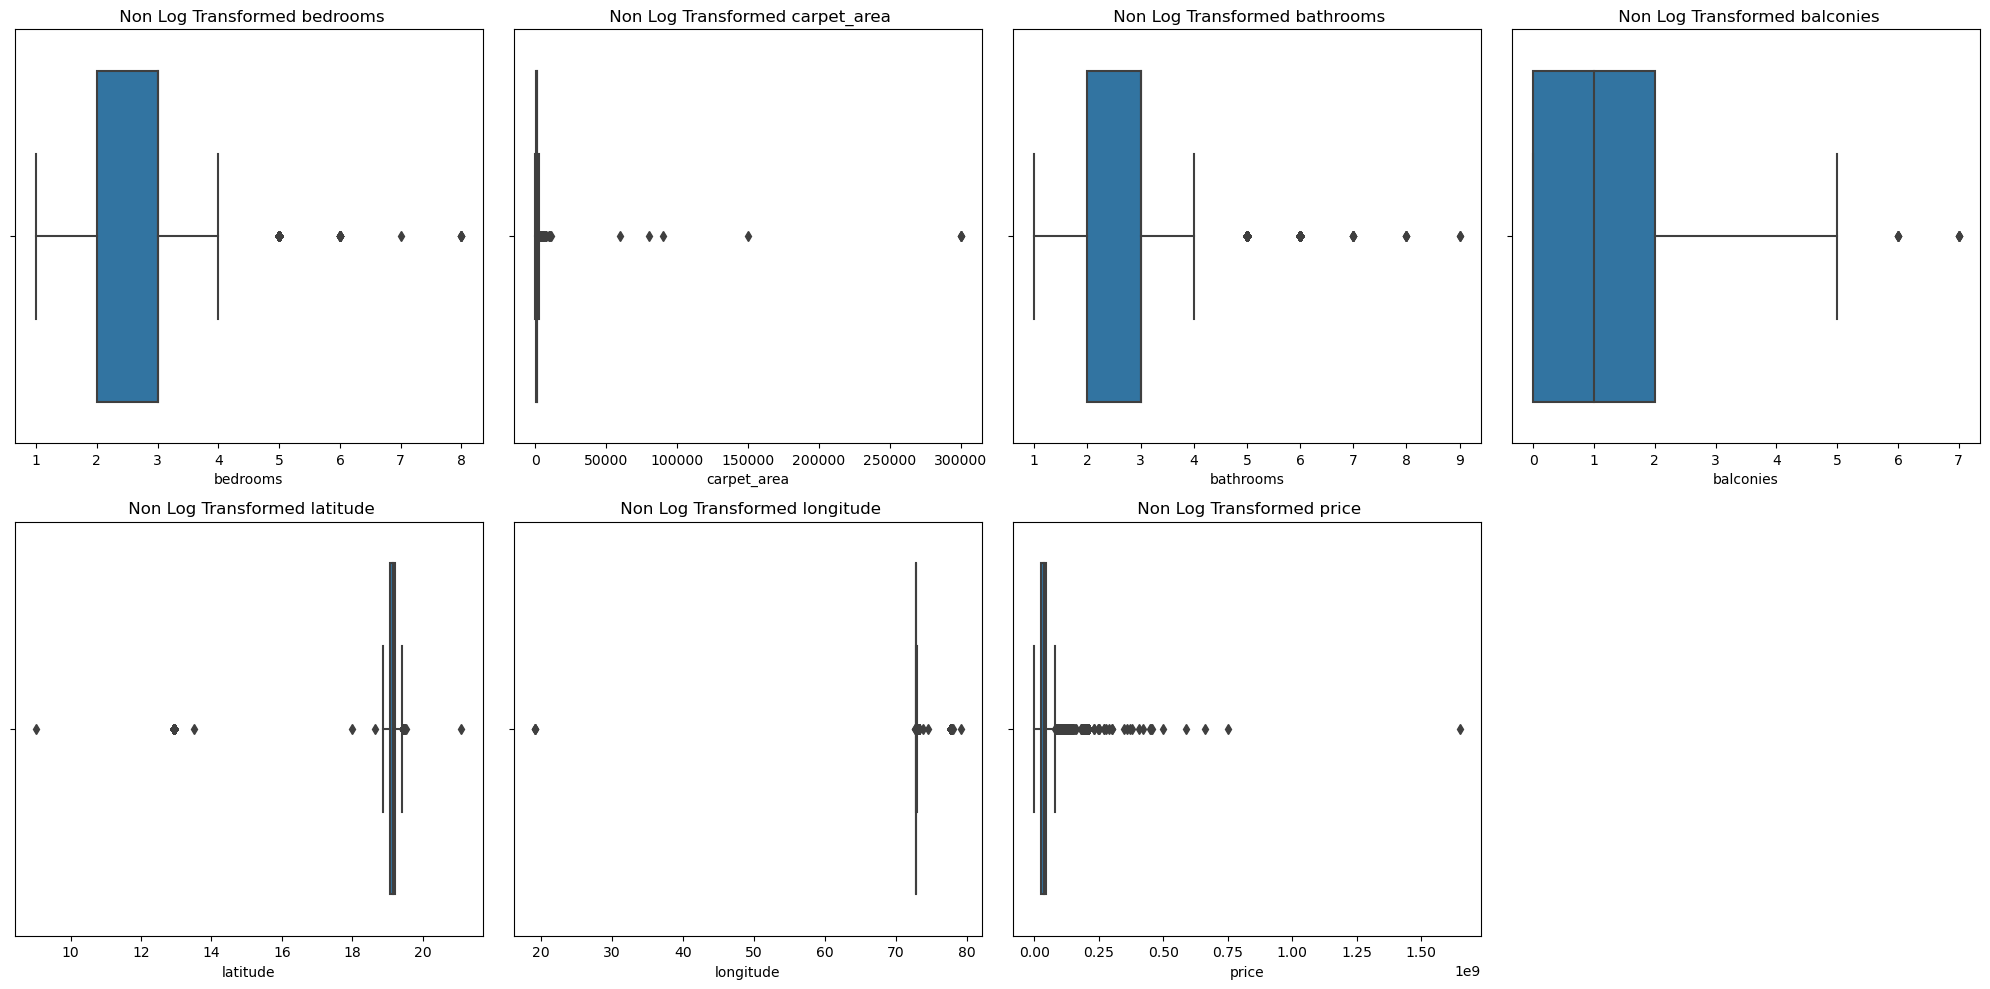

In [22]:
num_plots = len(numeric_cols)
rows = (num_plots // 4) + (num_plots % 4 > 0) 
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten() 

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f' Non Log Transformed {col}')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Fixing outliers in bedrooms column:

In [23]:
df['bedrooms'].describe()

count     54870.0
mean     2.754584
std       0.96713
min           1.0
25%           2.0
50%           3.0
75%           3.0
max           8.0
Name: bedrooms, dtype: Float64

In [24]:
print(df.query('bedrooms > 5').shape)
df.query('bedrooms > 5')[['bedrooms','carpet_area','bathrooms']].head(5)

(22, 11)


,bedrooms,carpet_area,bathrooms
19,6,7420,8
692,8,7000,8
746,6,2160,6
1576,6,2640,6
1892,6,10500,6


In [25]:
# Removing bedrooms greater than 5.
print(df.shape)
df = df.query('bedrooms <= 5 ')


(54870, 11)


#### Outlier treatment in carpet area column:

In [26]:
# Outlier treatment in carpet area:
df['carpet_area'].describe()

count        54848.0
mean     1196.174446
std      2027.521436
min              1.0
25%            773.0
50%            950.0
75%           1452.0
max         300000.0
Name: carpet_area, dtype: Float64

In [27]:
# We will drop carpet_area less than 140 Sqft.
print("Rows with carpet area less than 140sqft: ",df.query('carpet_area < 140').shape)

df = df.query('carpet_area >= 140')
print(df.query('carpet_area < 140').shape)

print(df.shape)

Rows with carpet area less than 140sqft:  (9, 11)
(0, 11)
(54839, 11)


In [28]:
# We will drop rows where carpet_area has no relation wit bedrooms.
print(df.query('carpet_area < 745  & bedrooms > 2').shape)

df.query("not (carpet_area < 745 and bedrooms > 2)", inplace=True)
print(df.shape)

(7, 11)
(54832, 11)


In [29]:
# Dropping rows where carpet_area doesnt align with no of bedrooms:
print(df.query('carpet_area > 1561 & bedrooms < 3').shape)

df = df.query('not (carpet_area > 1561 & bedrooms < 3)')
print(df.shape)

(15, 11)
(54817, 11)


#### Outlier treatment in balconies column:

In [30]:
# Dropping outliers in balconies: Maintaining balance between noof balconies and bedrooms.

print(df.query('balconies > 5 & bedrooms < 5 ').shape)
print(df.query('balconies > 3 & bedrooms < 2 ').shape)
print(df.query('balconies > 4 & bedrooms < 3 ').shape)

(6, 11)
(5, 11)
(5, 11)


In [31]:
df = df.drop(df.query('(balconies > 5 & bedrooms < 5) | (balconies > 3 & bedrooms < 2) | (balconies > 4 & bedrooms < 3)').index)
print(df.shape)

(54803, 11)


#### Outlier treatment in latitude and longitude:

Rows with latitude or longitude with empty values  0
           latitude     longitude
count  54803.000000  54803.000000
mean      18.951441     73.012980
std        1.072208      0.932086
min        9.023547     19.145018
25%       19.057763     72.836970
50%       19.148916     72.863440
75%       19.205002     72.879561
max       21.100768     79.094337


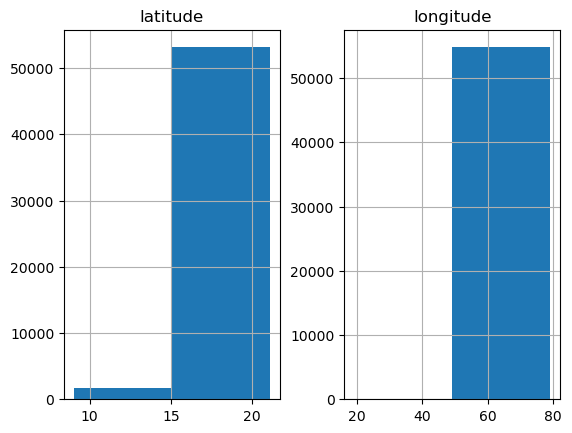

In [32]:
# Checking for issus in latitude and longitude: 
print("Rows with latitude or longitude with empty values ",df.query('latitude ==0 | longitude ==0').shape[0])

print(df[['latitude','longitude']].describe())
df[['latitude','longitude']].hist(bins=2)
plt.show()


In [33]:
# Checking how many locations have 0 co-ordinates to apply k means for model training: It is better to drop latitude and longitude columns.

location_df = df.query('latitude ==0 | longitude ==0')[['property_type','location','latitude','longitude']]
location_df['location'].nunique() # 410 locations with no latitude or longitude co-ordinates so applying k means in not possible.

0

#### Outlier treatment in location column:

In [34]:
df['location'].nunique()

510

In [35]:
df['location'].value_counts().sort_values(ascending=True).head(3)

location
Waliv                      1
BMC Colony Kurla West      1
Tapovan Housing Complex    1
Name: count, dtype: int64

In [36]:
# There are total 285 improper locations with value 1: We will remove those location rows 

print("Rows with location value count 1 = ",(df['location'].value_counts() == 1).sum())
print("Rows with location value count more than 1 = ",(df['location'].value_counts() > 1).sum())

Rows with location value count 1 =  233
Rows with location value count more than 1 =  277


In [37]:
df = df[df['location'].map(df['location'].value_counts()) > 1]
print(df.shape)
print("Location count after cleaning ",df['location'].nunique())

(54570, 11)
Location count after cleaning  277


#### Outlier treatment in bathrooms column:

Removing Bathrooms more than 5

In [38]:
df['bathrooms'].describe()

count     54570.0
mean     2.954682
std      1.065425
min           1.0
25%           2.0
50%           3.0
75%           3.0
max           8.0
Name: bathrooms, dtype: Float64

In [39]:
print(df.query('bathrooms > 5').shape)
df = df.query('bathrooms <= 6')

print(df['bathrooms'].unique())

(1685, 11)
<IntegerArray>
[3, 2, 5, 4, 1, 6]
Length: 6, dtype: Int64


### Outlier treatment price column:

In [40]:
df['price'].describe()

count            54566.0
mean     45594185.180607
std       43846788.15309
min             150000.0
25%           24328000.0
50%           36500000.0
75%           47000000.0
max         1650000000.0
Name: price, dtype: Float64

In [41]:
print(df['price'].quantile(0.75))
print(df['price'].quantile(0.80))

df[df['price'] > df['price'].quantile(0.95)].shape


47000000.0
50200000.0


(1693, 11)

In [42]:
print(df.query('price > 150000000 ').shape)
print(df.query('price <= 150000000').shape)

(3370, 11)
(51196, 11)


In [43]:
# Removed rows where price is above 15 crore but kept the juhu proeprties:
df = df.query('price <= 150000000 | location == "Juhu"')
print(df.shape)

(52870, 11)


### Univariate analysis:


### Histogram's for analyzing Distribution

In [44]:
numeric_cols

Index(['bedrooms', 'carpet_area', 'bathrooms', 'balconies', 'latitude',
       'longitude', 'price'],
      dtype='object')

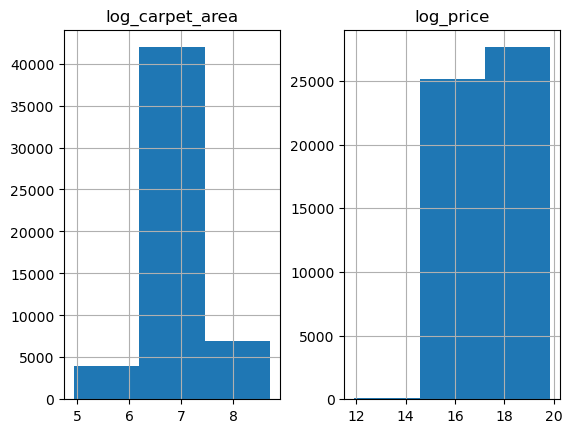

In [45]:
df['log_carpet_area'] = np.log(df['carpet_area'])
df['log_price'] = np.log(df['price'])

df[['log_carpet_area', 'log_price']].hist(bins=3)
plt.show()

### Bivariate Analysis:

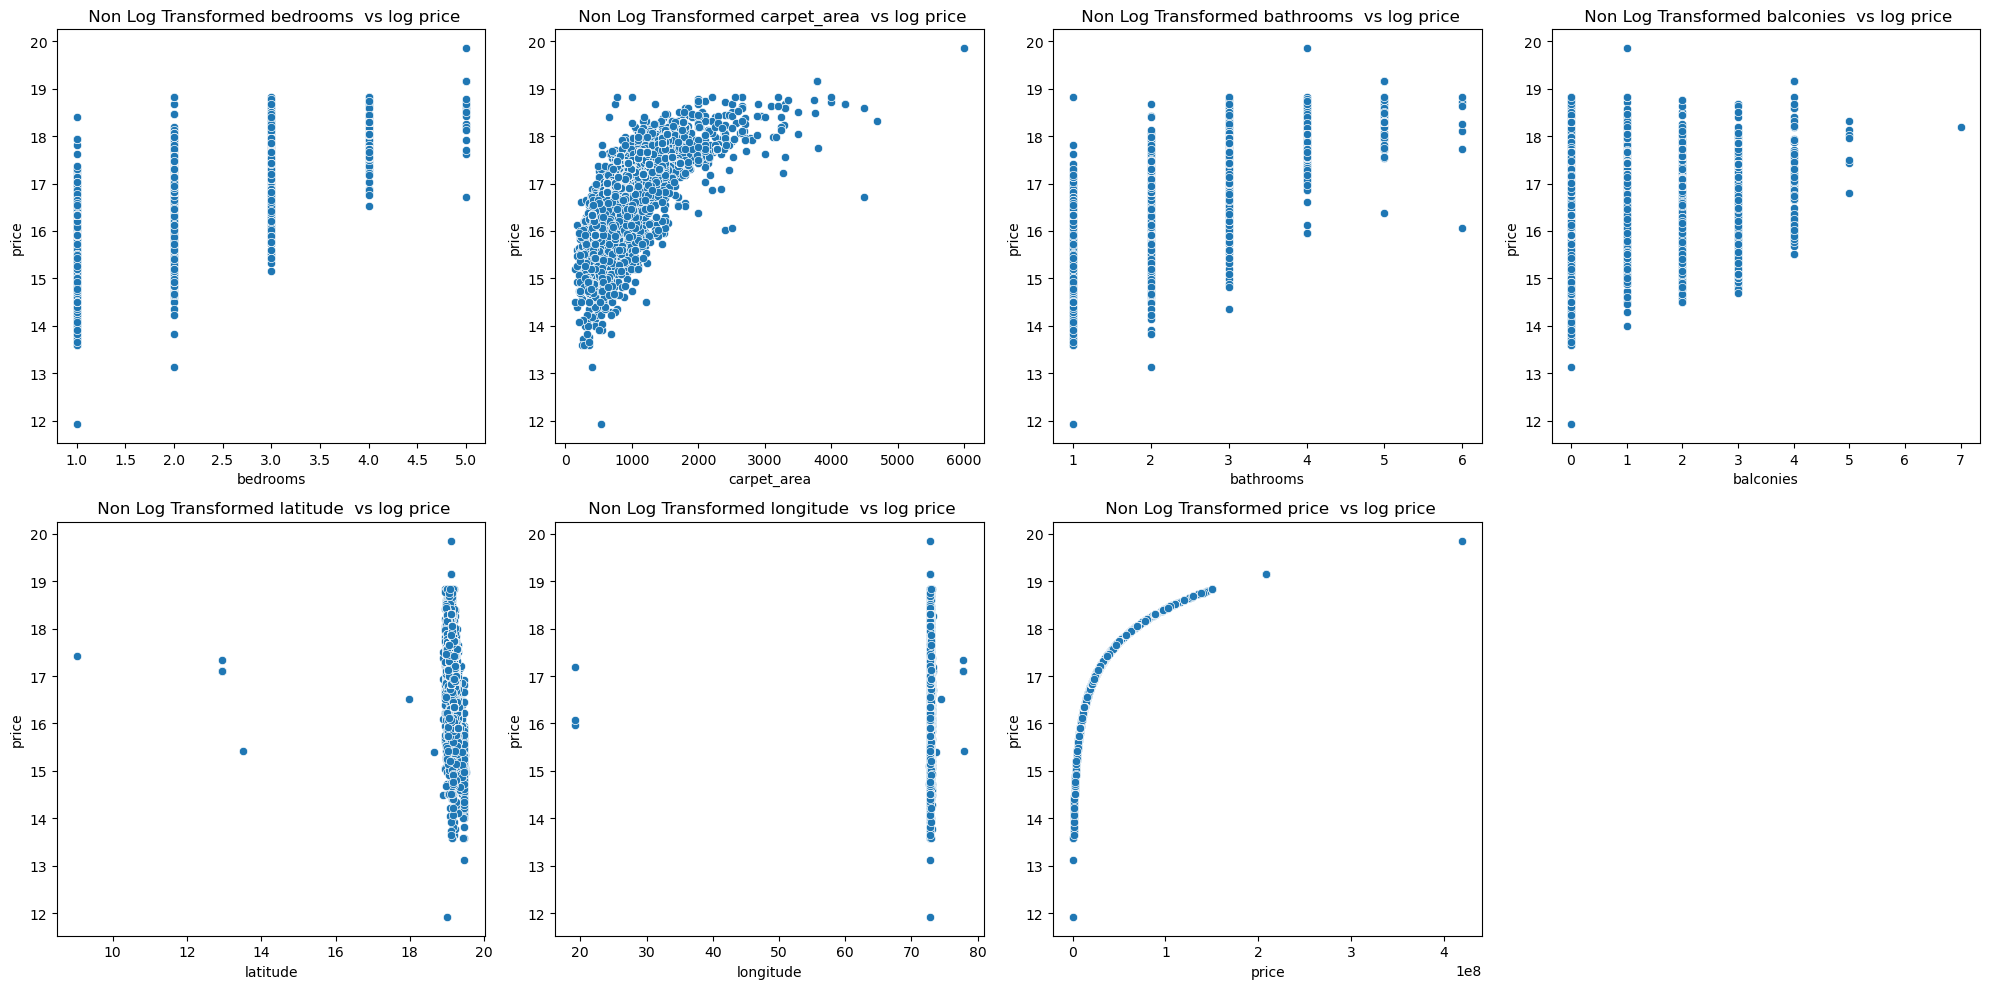

In [46]:
num_plots = len(numeric_cols)
rows = (num_plots // 4) + (num_plots % 4 > 0) 
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten() 

for i, col in enumerate(numeric_cols):
    sns.scatterplot(data=df,x=df[col],y=np.log(df['price']), ax=axes[i])
    axes[i].set_title(f' Non Log Transformed {col}  vs log price')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [47]:
df.head(2)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,latitude,longitude,price,log_carpet_area,log_price
0,New Property,Unfurnished,3,992,3,0,Under Construction,Sion,19.052807,72.872584,33150000,6.899723,17.316553
1,New Property,Semi-Furnished,2,580,2,0,Under Construction,Navghar Road,19.304890,72.866211,11054551,6.363028,16.218353


### Bivariate analysis: Categorical features

In [48]:
categorical_cols

Index(['property_type', 'furnish_status', 'poss_status', 'location'], dtype='object')

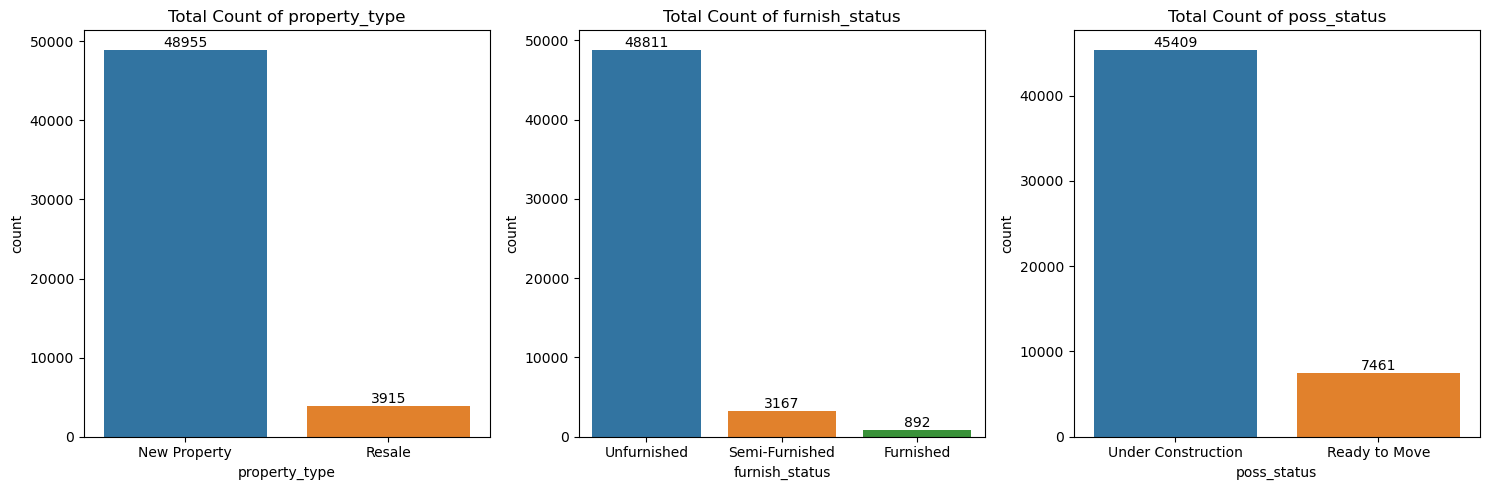

In [49]:
cols = categorical_cols.drop('location')

# Create subplots (1 row, multiple columns)
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 5))

for col, ax in zip(cols, axes):
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f"Total Count of {col}")
    ax.bar_label(ax.containers[0])

plt.tight_layout() 
plt.show()

<Axes: title={'center': 'Top 10 Locality by highest average price'}, ylabel='location'>

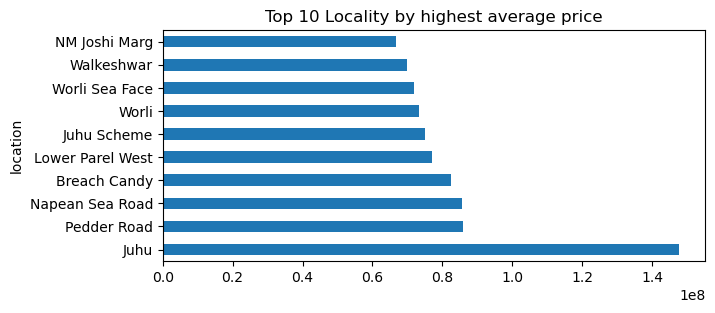

In [50]:
df.groupby('location')['price'].mean().astype('int').reset_index().sort_values(by='price',ascending=False).head(10) \
 .plot(kind='barh',x='location',y='price',figsize=(7,3),title="Top 10 Locality by highest average price",legend=False,)

<Axes: title={'center': 'Top 10 Locality by Lowest average price'}, ylabel='location'>

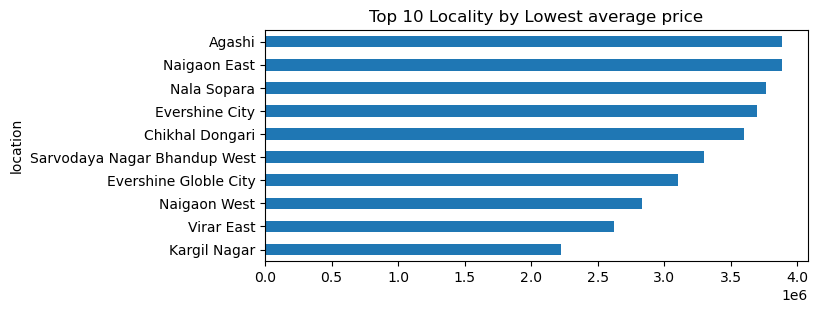

In [51]:
df.groupby('location')['price'].mean().astype('int').reset_index().sort_values(by='price',ascending=True).head(10) \
 .plot(kind='barh',x='location',y='price',figsize=(7,3),title="Top 10 Locality by Lowest average price",legend=False)

<Axes: title={'center': "Highest No of flat listing's per location"}, ylabel='location'>

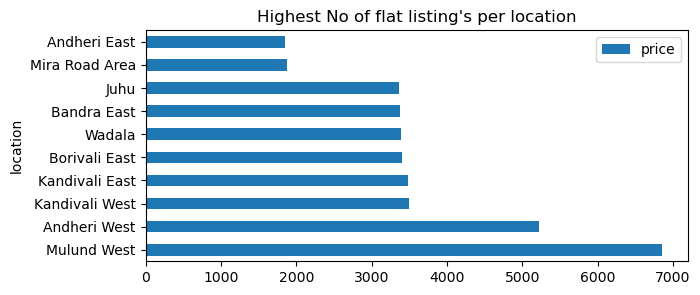

In [52]:
df.groupby('location')['price'].count().reset_index().sort_values(by='price',ascending=False).head(10) \
.plot(kind='barh',x='location',y='price',figsize=(7,3),title="Highest No of flat listing's per location")

### Visualizing Co-relation Matrix

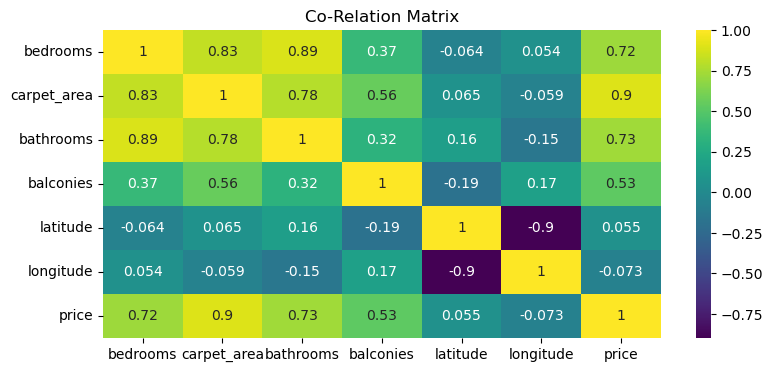

In [53]:
cm  = df[numeric_cols].corr()

plt.figure(figsize=(9,4))
plt.title("Co-Relation Matrix")
sns.heatmap(cm,annot=True,cmap='viridis')
plt.show()

### Co-relation of categorical columns (Annova F-Test):

In [54]:
from scipy.stats import f_oneway

categorical_cols = ['location', 'property_type', 'poss_status', 'furnish_status']

for col in categorical_cols:
    groups = [df[df[col] == value]['price'] for value in df[col].unique()]
    
    f_stat, p_value = f_oneway(*groups)
    
    print(f"ANOVA for {col}:")
    print(f"  F-statistic: {f_stat:.2f}, P-value: {p_value:.5f}\n")


ANOVA for location:
  F-statistic: 608.62, P-value: 0.00000

ANOVA for property_type:
  F-statistic: 1513.86, P-value: 0.00000

ANOVA for poss_status:
  F-statistic: 3646.97, P-value: 0.00000

ANOVA for furnish_status:
  F-statistic: 1140.53, P-value: 0.00000



## Feature Engineering and Encoding:

In [55]:
df.columns

Index(['property_type', 'furnish_status', 'bedrooms', 'carpet_area',
       'bathrooms', 'balconies', 'poss_status', 'location', 'latitude',
       'longitude', 'price', 'log_carpet_area', 'log_price'],
      dtype='object')

#### Removing columns which dont affect target(price):

In [56]:
df = df.drop(columns=['latitude', 'longitude', 'log_carpet_area', 'log_price'], axis=1)
df.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,price
0,New Property,Unfurnished,3,992,3,0,Under Construction,Sion,33150000
1,New Property,Semi-Furnished,2,580,2,0,Under Construction,Navghar Road,11054551
2,New Property,Unfurnished,2,795,2,1,Under Construction,Andheri East,25000000


#### Generating New Feature Price per sqrft:

In [57]:
df['price_per_sqrft'] = (df['price'] / df['carpet_area']).astype('int')

df.head(2)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,price,price_per_sqrft
0,New Property,Unfurnished,3,992,3,0,Under Construction,Sion,33150000,33417
1,New Property,Semi-Furnished,2,580,2,0,Under Construction,Navghar Road,11054551,19059


#### Encoding property_type , furnish_staus,poss_status columns:

In [58]:
print(df['property_type'].unique())
print(df['furnish_status'].unique())
print(df['poss_status'].unique())

['New Property' 'Resale']
['Unfurnished' 'Semi-Furnished' 'Furnished']
['Under Construction' 'Ready to Move']


In [59]:
df_encoded = df

df_encoded['property_type'] = df['property_type'].map({'Resale':0 , 'New Property':1})
df_encoded['furnish_status'] = df['furnish_status'].map({'Unfurnished':0, 'Semi-Furnished':1, 'Furnished':2})
df_encoded['poss_status'] = df['poss_status'].map({'Under Construction':0 , 'Ready to Move':1})

df_encoded.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,location,price,price_per_sqrft
0,1,0,3,992,3,0,0,Sion,33150000,33417
1,1,1,2,580,2,0,0,Navghar Road,11054551,19059
2,1,0,2,795,2,1,0,Andheri East,25000000,31446


### Encoding location using Target encoding.

In [60]:
# Save all unique locations
location_names = df_encoded['location'].unique().tolist()

# Save mapping of location → mean price
location_encoding_map = df_encoded.groupby('location')['price'].mean().astype('int').to_dict()

# Create reverse mapping for decoding
reverse_location_map = {v: k for k, v in location_encoding_map.items()}

In [61]:
avg_price_location = df_encoded.groupby('location')['price'].mean().astype('int')

df_encoded['location_encoded'] = df_encoded['location'].map(avg_price_location)
df_encoded.drop('location',axis=1,inplace=True)
df_encoded.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,poss_status,price,price_per_sqrft,location_encoded
0,1,0,3,992,3,0,0,33150000,33417,32779556
1,1,1,2,580,2,0,0,11054551,19059,8077119
2,1,0,2,795,2,1,0,25000000,31446,20388417


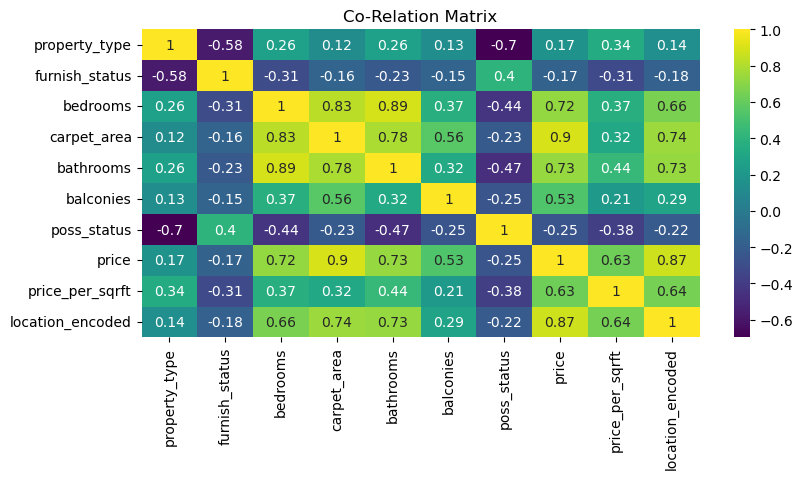

In [62]:
numeric_cols = df_encoded.select_dtypes(exclude=['object']).columns

cm = df[numeric_cols].corr()
plt.figure(figsize=(9,4))
plt.title("Co-Relation Matrix")
sns.heatmap(cm,annot=True,cmap='viridis')
plt.show()

In [63]:
df_encoded = df_encoded.drop('poss_status',axis=1)
df_encoded.head(2)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,price,price_per_sqrft,location_encoded
0,1,0,3,992,3,0,33150000,33417,32779556
1,1,1,2,580,2,0,11054551,19059,8077119


## Model Training:

In [64]:
X = df_encoded.drop('price',axis=1)
y = df['price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

print(df.shape)
print("X_train and X_test", X_train.shape,X_test.shape)
print("y_train and y_test" ,y_train.shape,y_test.shape)

(52870, 10)
X_train and X_test (37009, 8) (15861, 8)
y_train and y_test (37009,) (15861,)


In [65]:
# Lets create a custom function for model training and calculating the metrics:

def calculate(model):
     model.fit(X_train,y_train)
     y_pred = model.predict(X_test)
     
     train_score = model.score(X_train,y_train)
     test_score = model.score(X_test,y_test)
     mse = mean_squared_error(y_test,y_pred)
     rmse = np.sqrt(mse)
     r2 = r2_score(y_test,y_pred)

     print( f"Model => {model} ")
     
     print(f"train score = {round(train_score,2)}")
     print(f"test score = {round(test_score,2)}")
     print(f"Rmse = {round(rmse,2)}" )
     print(f"r2 score = {round(r2,2)}")
     

In [66]:
calculate(LinearRegression())

Model => LinearRegression() 
train score = 0.96
test score = 0.96
Rmse = 7047152.04
r2 score = 0.96


In [67]:
calculate(Ridge())

Model => Ridge() 
train score = 0.96
test score = 0.96
Rmse = 7047143.62
r2 score = 0.96


In [68]:
calculate(RandomForestRegressor())

Model => RandomForestRegressor() 
train score = 1.0
test score = 1.0
Rmse = 1362252.89
r2 score = 1.0


In [69]:
calculate(XGBRegressor())

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 1.0
test score = 1.0
Rmse = 1504274.91
r2 score = 1.0


## Model Fine Tuning:

In [70]:
rf_params = {
    'max_depth':20,
    'min_samples_leaf':10,
    'n_estimators':300,
    'max_features':'sqrt'
}

# calculate(RandomForestRegressor(**rf_params,random_state=42))

In [71]:
rf_params1 = {
    'n_estimators': 1000,
    'max_depth': 20,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'auto',
    'bootstrap': False
}

# calculate(RandomForestRegressor(**rf_params1,random_state=42))

In [72]:
calculate(XGBRegressor())

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 1.0
test score = 1.0
Rmse = 1504274.91
r2 score = 1.0


In [73]:
xgb_params = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
}

calculate(XGBRegressor(**xgb_params))

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 1.0
test score = 1.0
Rmse = 1355359.68
r2 score = 1.0


In [74]:
xgb_params1 = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'gamma': 3,
    'reg_alpha': 1,
    'reg_lambda': 5,
}

calculate(XGBRegressor(**xgb_params1))

Model => XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) 
train score = 1.0
test score = 1.0
Rmse = 1490433.08
r2 score = 1.0


## Error margin:

In [75]:
X_train.columns

Index(['property_type', 'furnish_status', 'bedrooms', 'carpet_area',
       'bathrooms', 'balconies', 'price_per_sqrft', 'location_encoded'],
      dtype='object')

In [76]:
best_model = XGBRegressor(**xgb_params1)
best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct =  residuals *100 / y_test

results_df = pd.DataFrame(
    {'Actual_value': y_test,
    'predicted_value': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
    }
)

results_df.head(3)

,Actual_value,predicted_value,diff,diff_pct
56405,36500000,36501584.0,1584.0,0.00434
17771,26700000,26706774.0,6774.0,0.025371
13982,20400000,20416090.0,16090.0,0.078873


### Feature Importance:

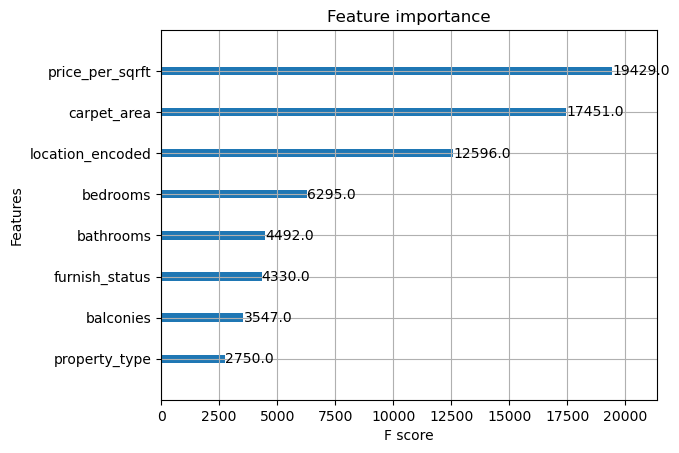

In [77]:
from xgboost import plot_importance
plot_importance(best_model)
plt.show()

In [78]:
np.abs(results_df['diff_pct']).describe()

count     15861.0
mean     0.599054
std      4.356202
min      0.000705
25%      0.006452
50%       0.01047
75%      0.052205
max       262.449
Name: diff_pct, dtype: Float64

In [79]:
results_df[np.abs(results_df['diff_pct']) > 10].shape

(221, 4)

In [80]:
extreme_error_threshold = 10  # Threshold of 10% to calculate errors more than 10%.
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
print(extreme_results_df.shape)
extreme_results_df.head()

(221, 4)


,Actual_value,predicted_value,diff,diff_pct
3557,61218107,53976596.0,-7241511.0,-11.829035
3001,8000000,6583509.0,-1416491.0,-17.706138
7130,130000000,94867368.0,-35132632.0,-27.025102
538,34900000,31303978.0,-3596022.0,-10.303788
3621,19000000,22156650.0,3156650.0,16.613947


In [81]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

1.3933547695605573

#### For Error margin of more than 10% we have 221 rows.

#### This means for 1.39% of flats we will predict the price by more or less than 10%

## Reverse Scaling: Checking from where these errors are coming from 

In [82]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(3)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,price_per_sqrft,location_encoded
3557,0,0,1,1086,2,0,56370,24032781
3001,0,0,1,340,1,0,23529,13547058
7130,0,2,3,1350,3,0,96296,47947121


In [83]:
# Check which locations have high errors
extreme_errors_df['location_encoded'].value_counts().head(10)

location_encoded
58532209    13
34472776    11
55884536     9
16938483     8
41336241     7
38788636     7
20388417     7
28575646     7
45282965     6
4267470      6
Name: count, dtype: int64

In [84]:
df_encoded.head(1)

,property_type,furnish_status,bedrooms,carpet_area,bathrooms,balconies,price,price_per_sqrft,location_encoded
0,1,0,3,992,3,0,33150000,33417,32779556


In [85]:
print(location_names[:5])
print(location_encoding_map)
print(reverse_location_map)

['Sion', 'Navghar Road', 'Andheri East', 'Kandivali West', 'Mulund West']
{'Agashi': 3883333, 'Agripada': 29625000, 'Akurli Nagar': 15225000, 'Amar Nagar Mulund West': 10596666, 'Ambivali': 4280000, 'Amboli': 26000000, 'Andheri': 10250000, 'Andheri East': 20388417, 'Andheri West': 58532209, 'Azad Nagar 2': 24533333, 'Azad Nagar Andheri West': 24500000, 'Babrekar Nagar Kandivali West': 11975000, 'Bander Pakhadi': 13450000, 'Bandra': 18000000, 'Bandra East': 30931504, 'Bandra Kurla Complex': 51431000, 'Bandra West': 47947121, 'Bangur Nagar': 24312500, 'Battipada': 11500000, 'Best Nagar Goregaon West': 61250000, 'Beverly Park': 7845020, 'Bhabola': 9700000, 'Bhandup': 15171500, 'Bhandup East': 10005000, 'Bhandup West': 13261686, 'Bhavani Nagar Marol': 20250000, 'Bhayandar East': 7135217, 'Bhayandar West': 9391538, 'Bolinj': 4907125, 'Borivali East': 28908892, 'Borivali West': 24373191, 'Breach Candy': 82500000, 'Byculla': 35650557, 'Byculla East': 41840721, 'Byculla West': 48860000, 'Centr

In [86]:
test_sample = {
    "property_type": 1,         # Example: 1 for resale, 0 for new
    "furnish_status": 0,        # Example: 0 = Unfurnished, 1 = Semi-furnished, 2 = Fully-furnished
    "bedrooms": 3,              # Example: 2 BHK
    "carpet_area": 992,         # Example: 850 sq. ft.
    "bathrooms": 3,             # Example: 2 bathrooms
    "balconies": 0,             # Example: 2 balconies
    "price_per_sqrft": 33417,   
    "location_encoded": 32779556     # Encoded value for location
}

test_df = pd.DataFrame([test_sample])
predicted_price = best_model.predict(test_df)
print(predicted_price)

[32899320.]


### Dumping Model and its artifacts:

In [87]:
# import joblib

# dump_data = {
#     'model': best_model,
#     'location_encoding_map': location_encoding_map,
#     'reverse_location_map': reverse_location_map,
#     'location_names': location_names,
# }

# joblib.dump(dump_data, 'real_estate_model.pkl')
